In [ ]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import torchvision
import torch
import lightning.pytorch as pl

from sklearn.decomposition import PCA
from src.model.full_model import SubCellProtModel,SubCellProtModel_bce
from src.utils.data_handling_utils import initialize_datasets, Retrieval_Data
from src.utils.batch_run_utils import batch_call, get_cell_lines_of_interest, get_isoforms_of_interest, construct_embedding_df
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import os
import time
from enum import Enum
import pdb
import pickle as pk
import math
from src.dataset.dataset import SubCellDatset, DatasetType, CLASSES
from PIL import Image

import sklearn
import sklearn.ensemble
import sklearn.neighbors

fig = plt.figure()

In [2]:
import seaborn as sns

In [3]:
COLLECTION_NAME = "splice_isoform_dataset_cell_line_and_gene_split_full"

MODEL_CHECKPOINT='checkpoints/splice_isoform_dataset_cell_line_and_gene_split_full-epoch=01-val_combined_loss=0.18.ckpt'


In [5]:
train_dataset, val_dataset, test_dataset, get_data = initialize_datasets(COLLECTION_NAME,if_alphabetical=True)
loaded_model = SubCellProtModel().load_from_checkpoint(
    MODEL_CHECKPOINT,
    collection_name=COLLECTION_NAME,
    batch_size=32,
)


In [6]:
#plot GO
from genes_ncbi_human_proteinCoding import GENEID2NT as GeneID2nt_hs
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

In [7]:
obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()

mapper = {}

for key in GeneID2nt_hs:
    mapper[GeneID2nt_hs[key].Symbol] = GeneID2nt_hs[key].GeneID
    
inv_map = {v: k for k, v in mapper.items()}

# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(fin_gene2go, taxids=[9606])
ns2assoc = objanno.get_ns2assc()

  EXISTS: go-basic.obo
  EXISTS: gene2go
HMS:0:01:35.230690 345,219 annotations, 20,760 genes, 18,774 GOs, 1 taxids READ: gene2go 


In [8]:
obodag = GODag("go-basic.obo")

go-basic.obo: fmt(1.2) rel(2023-11-15) 46,228 Terms


In [9]:
ns2assoc={'BP':ns2assoc['BP']}
goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_hs.keys(),
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, 
        methods = ['fdr_bh']) 
GO_items = []

temp = goeaobj.ns2objgoea['BP'].assoc
for item in temp:
    GO_items += temp[item]


Load BP Ontology Enrichment Analysis ...
 82% 17,010 of 20,651 population items found in association


In [10]:
def go_it_all(test_genes):
    print(f'input genes: {len(test_genes)}')
    
    mapped_genes = []
    for gene in test_genes:
        try:
            mapped_genes.append(mapper[gene])
        except:
            pass
    print(f'mapped genes: {len(mapped_genes)}')
    
    goea_results_all = goeaobj.run_study(mapped_genes)
    GO = pd.DataFrame(list(map(lambda x: [x.GO, x.goterm.name, x.goterm.namespace, x.p_uncorrected, x.p_fdr_bh,\
                   x.ratio_in_study[0], x.ratio_in_study[1], GO_items.count(x.GO), list(map(lambda y: inv_map[y], x.study_items)),\
                   ], goea_results_all)), columns = ['GO', 'term', 'class', 'p', 'p_corr', 'n_genes',\
                                                    'n_study', 'n_go', 'study_genes'])

    GO = GO[GO.n_genes > 0]
    return GO

In [12]:
testCellLines=np.array(['NB4', 'MCF7', 'THP1', 'U251MG', 'GAMG', 'HeLa', 'A549', 'HEK293'])


In [35]:
from pymongo import MongoClient
with MongoClient(maxPoolSize=500) as client:
    dataset_collection = client.hpa_old[COLLECTION_NAME]
    isoform_grouping = list(
        dataset_collection.aggregate(
            [{"$group": {"_id": "$splice_isoform_id", "ids": {"$push": "$_id"}}}],
            allowDiskUse=True,
        )
    )

In [30]:
cell_line_grouping = None
with MongoClient(maxPoolSize=500) as client:
    dataset_collection = client.hpa_old[COLLECTION_NAME]
    cell_line_grouping = list(
        dataset_collection.aggregate(
            [{"$group": {"_id": "$cell_line", "ids": {"$push": "$_id"}}}],
            allowDiskUse=True,
        )
    )

In [31]:
cellIDbyCellLine={}
for clidx in cell_line_grouping:
    if clidx['_id'] in testCellLines:
        cellIDbyCellLine[clidx['_id']]=np.array(clidx['ids'])

In [32]:
savedir_log='losses/log/'
with open(os.path.join(savedir_log,'nucProp_p_cl_thresh'), 'rb') as output:
    nucProp_p_cl_thresh=pk.load(output)

In [36]:
isoform_grouping_names=np.array([isoform_grouping[pidx]['_id'] for pidx in range(len(isoform_grouping))])

In [38]:
ntopP=200

nucProp_p_cl_thresh_var=np.std(nucProp_p_cl_thresh,axis=1)
rankThreshVarPidx=np.argsort(-nucProp_p_cl_thresh_var)

rankThreshVarPidx_unique=np.zeros(ntopP).astype(int)
topIsoformNames_unique=np.repeat('-',ntopP).astype(object)
pCount=0
for pidx in range(len(isoform_grouping)):
    pcurr=isoform_grouping_names[rankThreshVarPidx[pidx]]
    pcurr=pcurr.split('-')[0]
    if pcurr not in topIsoformNames_unique:
        topIsoformNames_unique[pCount]=pcurr
        rankThreshVarPidx_unique[pCount]=rankThreshVarPidx[pidx]
        pCount+=1
    if pCount==ntopP:
        break

In [40]:
topIsoformGO=go_it_all(topIsoformNames_unique)

input genes: 200
mapped genes: 188

Runing BP Ontology Analysis: current study set of 188 IDs.
 89%    167 of    188 study items found in association
100%    188 of    188 study items found in population(20651)
Calculating 12,220 uncorrected p-values using fisher_scipy_stats
  12,220 terms are associated with 17,010 of 20,651 population items
     927 terms are associated with    167 of    188 study items
  METHOD fdr_bh:
       7 GO terms found significant (< 0.05=alpha) (  7 enriched +   0 purified): statsmodels fdr_bh
      71 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


In [41]:
topIsoformGO.index=topIsoformGO.GO

In [58]:
gene2go={}
for go in topIsoformGO.index:
    for g in topIsoformGO.loc[go].study_genes:
        if g in gene2go.keys():
            gene2go[g].append(go)
        else:
            gene2go[g]=[go]

20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


/tmp/ipykernel_1833473/2879161226.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


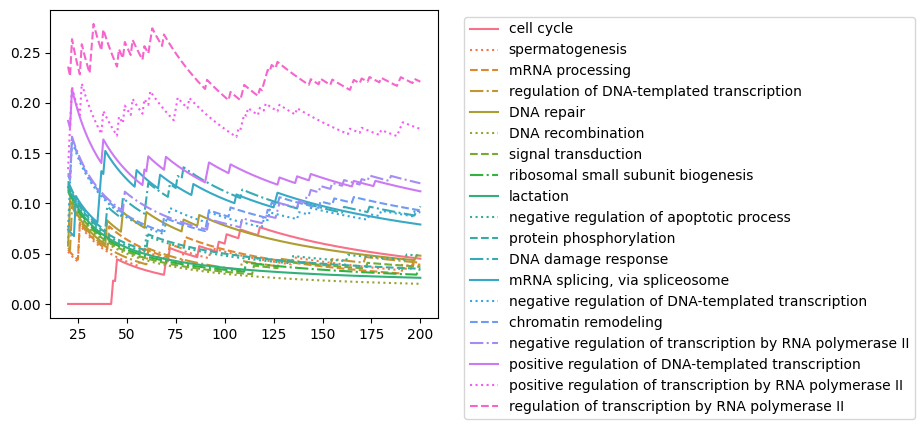

In [65]:
#plot %genes with the term
k_start=20
k_end=ntopP
nGoPlot=20
colortest=sns.color_palette("husl", nGoPlot)
linestyles=['solid','dotted','dashed','dashdot']

go_genecounts=np.zeros((topIsoformGO.shape[0],k_end-k_start+1))
kidx=0
for k in range(k_start,k_end+1):
    print(k)
    kisoforms=topIsoformNames_unique[:k]
    goIdx=0
    for go in topIsoformGO.index:
        go_genecounts[goIdx,kidx]=np.intersect1d(kisoforms,topIsoformGO.loc[go].study_genes).size/k
        goIdx+=1
    kidx+=1
go_geneCounts_rank=np.argsort(np.max(go_genecounts,axis=1))
fig, ax = plt.subplots(figsize=(5, 4))
lines=[]
plotCount=0
xrange=np.arange(k_start,k_end+1)
for gidx_ in range(topIsoformGO.shape[0]):
    gidx=go_geneCounts_rank[gidx_]

    if gidx_>topIsoformGO.shape[0]-nGoPlot:
        c=colortest[plotCount]
        line_i,=ax.plot(xrange,go_genecounts[gidx]+0.002*plotCount,color=c,label=topIsoformGO.iloc[gidx].term,linestyle=linestyles[plotCount%len(linestyles)])
        lines.append(line_i)
        plotCount+=1
#     else:
#         c='gray'
#         ax.plot(xrange,go_genecounts[gidx],color=c)
# plt.ylim(30,100)
ax.legend(handles=lines,bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig(os.path.join(savedir_log,'topGO_nogray_jitter_start20.pdf'))
plt.show()

/tmp/ipykernel_1833473/977817479.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


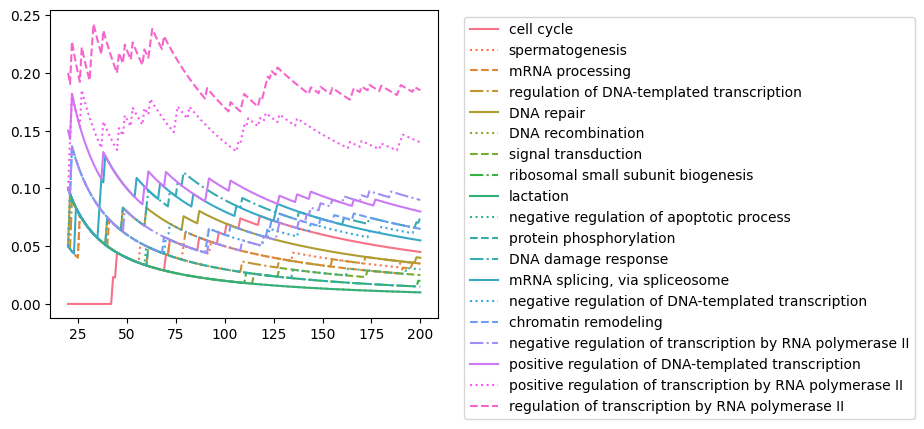

In [66]:
go_geneCounts_rank=np.argsort(np.max(go_genecounts,axis=1))
fig, ax = plt.subplots(figsize=(5, 4))
lines=[]
plotCount=0
xrange=np.arange(k_start,k_end+1)
for gidx_ in range(topIsoformGO.shape[0]):
    gidx=go_geneCounts_rank[gidx_]

    if gidx_>topIsoformGO.shape[0]-nGoPlot:
        c=colortest[plotCount]
        line_i,=ax.plot(xrange,go_genecounts[gidx],color=c,label=topIsoformGO.iloc[gidx].term,linestyle=linestyles[plotCount%len(linestyles)])
        lines.append(line_i)
        plotCount+=1
#     else:
#         c='gray'
#         ax.plot(xrange,go_genecounts[gidx],color=c)
# plt.ylim(30,100)
ax.legend(handles=lines,bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig(os.path.join(savedir_log,'topGO_nogray_start20.pdf'))
plt.show()

In [99]:
#plot genes that introduce new GO terms
coveredGOterms=[]
uniqueGObyK=np.zeros(ntopP)
for k in range(ntopP):
    pcurr=topIsoformNames_unique[k]
    if pcurr in gene2go.keys():
        print(pcurr)
        for g in gene2go[pcurr]:
            if g not in coveredGOterms:
                print(topIsoformGO.loc[g].term)
        print('\n')
        coveredGOterms=np.unique(np.concatenate((coveredGOterms,gene2go[pcurr])))
        
            
    uniqueGObyK[k]=coveredGOterms.size


CHID1
negative regulation of cytokine production involved in inflammatory response
innate immune response
carbohydrate metabolic process


APTX
regulation of protein stability
DNA ligation
single strand break repair


CAD
UDP biosynthetic process
'de novo' pyrimidine nucleobase biosynthetic process
response to testosterone
female pregnancy
cellular response to epidermal growth factor stimulus
'de novo' UMP biosynthetic process
liver development
response to cortisol
citrulline biosynthetic process
response to starvation
lactation
response to caffeine
UTP biosynthetic process
peptidyl-threonine phosphorylation
response to amine
response to insulin
glutamine metabolic process
animal organ regeneration
protein autophosphorylation
xenobiotic metabolic process
heart development


EXO1
DNA repair
meiotic cell cycle
humoral immune response mediated by circulating immunoglobulin
DNA recombination
somatic hypermutation of immunoglobulin genes
t-circle formation
isotype switching
mismatch repair


In [101]:
for g in gene2go['COPA']:
    print(topIsoformGO.loc[g].term)

pancreatic juice secretion
intra-Golgi vesicle-mediated transport
retrograde vesicle-mediated transport, Golgi to endoplasmic reticulum
signal transduction
intracellular protein transport
endoplasmic reticulum to Golgi vesicle-mediated transport


In [48]:
savedir_log='losses/log'
with open(os.path.join(savedir_log,'currTopPairs'), 'rb') as output:
    currTopPairs=pk.load(output)
with open(os.path.join(savedir_log,'currTopPairs_true'), 'rb') as output:
    currTopPairs_true=pk.load(output)

In [49]:
currTopPairs_overlap=[]
for p in currTopPairs:
    if p in currTopPairs_true:
        currTopPairs_overlap.append(p)

In [50]:
len(currTopPairs_overlap)

33

In [52]:
topIsoformGO_sc=go_it_all(currTopPairs_overlap)

input genes: 33
mapped genes: 26

Runing BP Ontology Analysis: current study set of 26 IDs.
 85%     22 of     26 study items found in association
100%     26 of     26 study items found in population(20651)
Calculating 12,220 uncorrected p-values using fisher_scipy_stats
  12,220 terms are associated with 17,010 of 20,651 population items
     158 terms are associated with     22 of     26 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


In [53]:
topIsoformGO_sc.index=topIsoformGO_sc.GO

In [54]:
gene2go_sc={}
for go in topIsoformGO_sc.index:
    for g in topIsoformGO_sc.loc[go].study_genes:
        if g in gene2go_sc.keys():
            gene2go_sc[g].append(go)
        else:
            gene2go_sc[g]=[go]

In [68]:
#plot %genes with the term
k_start=5
k_end=len(currTopPairs_overlap)

linestyles=['solid','dotted','dashed','dashdot']

go_genecounts_sc=np.zeros((topIsoformGO_sc.shape[0],k_end-k_start+1))
kidx=0
for k in range(k_start,k_end+1):
    print(k)
    kisoforms=currTopPairs_overlap[:k]
    goIdx=0
    for go in topIsoformGO_sc.index:
        go_genecounts_sc[goIdx,kidx]=np.intersect1d(kisoforms,topIsoformGO_sc.loc[go].study_genes).size/k
        goIdx+=1
    kidx+=1

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


/tmp/ipykernel_1833473/312916998.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


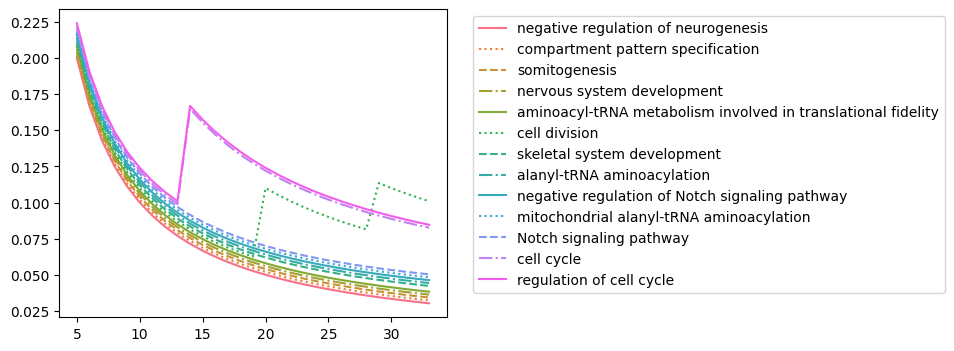

In [70]:
nGoPlot=14
colortest=sns.color_palette("husl", nGoPlot)

go_geneCounts_rank_sc=np.argsort(np.max(go_genecounts_sc,axis=1))
fig, ax = plt.subplots(figsize=(5, 4))
lines=[]
plotCount=0
xrange=np.arange(k_start,k_end+1)
for gidx_ in range(topIsoformGO_sc.shape[0]):
    gidx=go_geneCounts_rank_sc[gidx_]

    if gidx_>topIsoformGO_sc.shape[0]-nGoPlot:
        c=colortest[plotCount]
        line_i,=ax.plot(xrange,go_genecounts_sc[gidx]+0.002*plotCount,color=c,label=topIsoformGO_sc.iloc[gidx].term,linestyle=linestyles[plotCount%len(linestyles)])
        lines.append(line_i)
        plotCount+=1
#     else:
#         c='gray'
#         ax.plot(xrange,go_genecounts_sc[gidx],color=c)
# plt.ylim(30,100)
ax.legend(handles=lines,bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig(os.path.join(savedir_log,'topGO_sc_nogray_jitter.pdf'))
plt.show()

In [107]:
topIsoformGO_sc.shape[0]

158

In [108]:
topIsoformGO_sc

,GO,term,class,p,p_corr,n_genes,n_study,n_go,study_genes
GO,,,,,,,,,
GO:0051382,GO:0051382,kinetochore assembly,biological_process,0.000118,1.0,2,26,13,"[CENPT, CENPC]"
GO:0007059,GO:0007059,chromosome segregation,biological_process,0.000200,1.0,3,26,91,"[CENPT, CENPI, CENPC]"
GO:0042594,GO:0042594,response to starvation,biological_process,0.000988,1.0,2,26,37,"[DDIT3, BCAS3]"
GO:0009593,GO:0009593,detection of chemical stimulus,biological_process,0.001259,1.0,1,26,1,[DRGX]
GO:0051455,GO:0051455,spindle attachment to meiosis I kinetochore,biological_process,0.001259,1.0,1,26,1,[CENPC]
...,...,...,...,...,...,...,...,...,...
GO:0006357,GO:0006357,regulation of transcription by RNA polymerase II,biological_process,0.439296,1.0,3,26,1555,"[ESRRG, DDIT3, DRGX]"
GO:0045892,GO:0045892,negative regulation of DNA-templated transcrip...,biological_process,0.505826,1.0,1,26,552,[DDIT3]
GO:0030154,GO:0030154,cell differentiation,biological_process,0.524662,1.0,1,26,586,[DLL3]


In [111]:
#plot genes that introduce new GO terms
coveredGOterms_sc=np.array([])
uniqueGObyK_sc=np.zeros(len(currTopPairs_overlap))
for k in range(len(currTopPairs_overlap)):
    pcurr=currTopPairs_overlap[k]
    if pcurr in gene2go_sc.keys():
        print(pcurr)
        for g in gene2go_sc[pcurr]:
            if g not in coveredGOterms_sc:
                print(topIsoformGO_sc.loc[g].term)
        print('\n')
        coveredGOterms_sc=np.unique(np.concatenate((coveredGOterms_sc,gene2go_sc[pcurr])))
        
            
    uniqueGObyK_sc[k]=coveredGOterms_sc.size


AARS2
mitochondrial alanyl-tRNA aminoacylation
alanyl-tRNA aminoacylation
aminoacyl-tRNA metabolism involved in translational fidelity


DLL3
compartment pattern specification
paraxial mesoderm development
negative regulation of neurogenesis
negative regulation of Notch signaling pathway
somitogenesis
Notch signaling pathway
skeletal system development
cell differentiation


CABLES1
cell division
regulation of cell cycle
cell cycle
nervous system development


A4GALT
globoside biosynthetic process
glycosphingolipid biosynthetic process
plasma membrane organization
protein O-linked glycosylation


ABCA4
phospholipid transfer to membrane
retinol transport
phototransduction, visible light
retinal metabolic process
phospholipid translocation
retinoid metabolic process
photoreceptor cell maintenance
lipid transport
transmembrane transport
visual perception


DRGX
detection of chemical stimulus
sensory perception of mechanical stimulus
detection of temperature stimulus
trigeminal nerve devel

/tmp/ipykernel_1797162/970873738.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if g not in coveredGOterms_sc:
